### About the project

* Goal
    * I had experience with classical machine learning (ML)
    * Morten suggested the Bayesian approach
    * This project is a Bayesian version of a project others have done with classical ML


* I like deriving things from first principles
* That is what I have done here
* This might be long, but I was assured it was ok!

### Overview

1. General intro to Bayesian statistics
2. Bayesian regression (coded in NumPy)
3. Bayesian Convolutional Neural Network (coded in Tensorflow Probability)
4. Bayesian inference from one-off events

### Resources

* Books
    * _Data Analysis - A Bayesian Tutorial_ by Devinderjit Sivia
    * _Machine Learning: A Probabilistic Perspective_ by Kevin P. Murphy

* Articles
    * Shridhar et al. _Uncertainty Estimations by Softplus normalization in Bayesian Convolutional Neural Networks with Variational Inference_ https://arxiv.org/pdf/1806.05978.pdf
    * Wen et al. _Flipout: Efficient pseudo independent weight perturbations on mini-batches_ https://arxiv.org/pdf/1803.04386.pdf
    * LeCun et al. _Gradient-Based Learning Applied to Document Recognition_ http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
    * Mehta et al. _A high-bias, low-variance introduction to Machine Learning for physisits_ https://arxiv.org/pdf/1803.08823.pdf, https://physics.bu.edu/~pankajm/MLnotebooks.html

# Part 1 - Bayesian Statistics

### What is Bayesian statistics?

* An alternative to the __classical/frequentist__ school of statistics
* Difference:
    * Bayesian: Views probability as our subjective uncertainty about the world
        * The parameters are the random/uncertain variables
    * Classical: nature is random, probability represents that randomness
        * The data are the random/uncertain variables
    * The Prior
        * The most notable feature of Bayesian statistics
        * Incorporates prior information about the problem
        * Using various priors are often equivalent to regularization schemes in classical ML
        * Will get back to exactly what the prior is
    

### Benefits of the Bayesian approach 
* Hypothesis estimate is a distribution (pdf) in parameter space
    * Not just a point estimate, as with the classical approach
    * Gives information about the robustnes of the estimate
    * By comparing MAP to other nearby points
    * Lets you define Credible Intervals (CI)
        * "What people think confidence intervals is" - Murphy
        * Subtle difference, but credible intervals make more sense
    * Allows one to do probabilistic ML (part 3)
    
    
* Solutions to some pathologies that exist in classical statistics
    * E.g. inference from one-off events (part 4)
    
    
* More elegant
    * Various ML models are just special cases of the same idea
    * Feels more consistent/unified

### Bayes Theorem

* Everything is based on this equation

$${p(A|B) = \frac{p(B|A)p(A)}{p(B)}}$$



### Derivation of Bayes theorem

* We have two parameters $A$ and $B$. 
* $p(A,B)$ denotes the probability that both of those values are the true values of A and B.
* $p(A|B)$ denotes the probability that A is true given that B is true


* We then start with 


$$p(A,B) = p(A|B)p(B)$$


* Intuition:
    * We evaluate each in order



* Then since $p(A,B) = p(B,A)$ it must follow that


$$p(A|B)p(B) = p(B|A)p(A)$$


* Which leads to Bayes theorem


$${p(A|B) = \frac{p(B|A)p(A)}{p(B)}}$$


* Usually written as 


$$\boxed{p(A|B)  \propto p(B|A)p(A)}$$
    
* With $p(B)$ is as a normalization constant 
* Meaning $\int_A p(A'|B)dA' = 1$

### Bayesian Inference

* We have a dataset $D = \{d_1, d_2, .., d_N\}$ 
    * Measurements of value $y$ that is a function of a parameter vector $\vec{x}$
    * I.e. $d_i = y(\vec{x}^i | \boldsymbol{\theta})$
* $D$ and $X=[\vec{x}^1, \vec{x}^2, .., \vec{x}^N ]^T$ are known
* Want to find the function $y$ 
* Meaning we need to find its parameters $\boldsymbol{\theta}$ 
* (if the shape/form of $y$ is assumed) 


* Any parameter configuration $\boldsymbol{\theta}$ is a unique hypothesis 
* For any given $\boldsymbol{\theta}$, we want to know the probability of that hypothesis being true given the data, described as

$$
p(\boldsymbol{\theta}|D)
$$

* We can then use Bayes theorem to get


$$ 
\boxed{
p(\boldsymbol{\theta}|D)  \propto {p(D|\boldsymbol{\theta})p(\boldsymbol{\theta})}
}$$

* $p(D|\boldsymbol{\theta})$ is called the __likelihood function__ 
    * Probability of getting the data $D$ if $\boldsymbol{\theta}$ is true. 


* $p(\boldsymbol{\theta})$ is called the __prior distribution__  for the hypothesis, 
    * Probability distribution for various hypotheses $\boldsymbol{\theta}$ being true prior to seeing the data. 


* $p(\boldsymbol{\theta}|D)$ is known as the __posterior distribution__
    * Bayes theorem lets us create it from the prior and the likelihood
    * Describes the probability estimate for the inputted hypothesis



### Comparison to classical inference

* With classical statistical inference, one is only interested in the value for $\boldsymbol{\theta}$ that maximizes the probability of getting the obtained data, i.e.


$$
\hat{\boldsymbol{\theta}} = \underset{\boldsymbol{\theta}}{\text{argmax}} \ p(D|\boldsymbol{\theta})
$$


* $\hat{\boldsymbol{\theta}}$ is known as the MLE (maximum likelihood estimate).  
* Just a point estimate 
* No information about the robustness of the estimate

# Part 2 - Bayesian Regression on the 1D Ising model (with Noise)


### The 1D Ising Model (with noise)

* We randomly generate $N$ states of the 1D ising model 
    * Meaning N 1D vectors consisting of -1s and 1s 
* Then calculate their energies using the following Hamiltonian:

$$
H[\vec{x}^i] = J\sum_{j=1}^L [x_j^i x_{j+1}^i + x_{j+1}^i x_j^i] + \epsilon
$$

* Where $x_j^i$ is the j'th element of the i'th state $\vec{x}^i$
* We set the value $J=-0.5$ 
* The max energy is 40 so $\epsilon \sim \mathcal{N}(0,2.5)$ seems like a good choice.
* We will then try to see if we can re-extract this Hamiltonian from the data using Bayesian Linear regression.

In [ ]:
import numpy as np
import scipy.sparse as sp
np.random.seed(13)
import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')
### define Ising model aprams
L=40 # system size
# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(1400,L))

def ising_energies(states_, plot_true=False):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-0.5 # interaction between nearest-neighbors
        J[(i+1)%L,i]=-0.5
    # compute energies
    E = np.einsum('...i,ij,...j->...',states_,J,states_)
    
    if plot_true:
        import matplotlib.pyplot as plt
        %matplotlib inline
        import seaborn as sns

        sns.heatmap(J)
        plt.title("True Hamiltonian")
        plt.show()
    return E

### Plotting the Hamiltonian

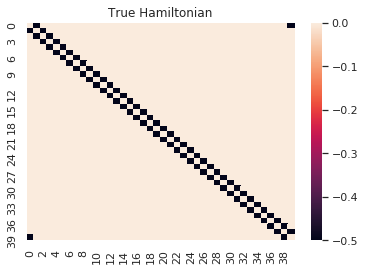

In [9]:
import seaborn as sns
sns.set()
# calculate Ising energies
energies=ising_energies(states,plot_true=True)

# Adding noise:
noise_variance = 2.5
energies += np.random.normal(0,scale=np.sqrt(noise_variance), size=energies.shape)

### Remapping data for regression

* We pretend that we're ignorant about the Hamiltonian used to generate the above data
* That means that the values aren't the only unknowns, but the shape of it as well
* We thus need to consider the __all-to-all Hamiltonian__

$$
H_{model}[\vec{x}^i] = \sum_{j=1}^L\sum_{k=1}^L J_{jk}x_j^ix_{k}^i + \epsilon
$$


* The actual Hamiltonian we used above is just a special case of this, with 

$$J_{jk} =-0.5 \cdot \max \big(\delta_{j,k-1}, \delta_{j,k+1}\big)$$



* We remap by taking the outer product


$$\vec{{x}} \rightarrow \phi(\vec{{x}})=\vec{{x}}\otimes \vec{{x}}$$


* Then we make the vector $\phi(\vec{x})$ one-dimensional.


* But we will write $\phi(\vec{x})$ as $\vec{x}$ for simplicity.

In [10]:
new_states = np.einsum('bi,bo->bio',states,states)
new_states = new_states.reshape(new_states.shape[0],-1)

### Performing the regression
* The goal is to create the posterior from the likelihood and the prior using


$$ p(\boldsymbol{\theta}|D)  \propto {p(D|\boldsymbol{\theta})p(\boldsymbol{\theta})}.$$

* where $\boldsymbol{\theta} = \{\vec{w}, \sigma^2\}$ 
    * $\sigma^2$ represents our estimation of $\epsilon$ in $H_\text{model}$
    * $\vec{w}$ is our estimation of the weights $\{J_{jk}\}$ 

* We thus need to specify the likelihood and the prior


* How this is done is of course problem dependent.

#### Choosing the Likelihood
* Common to make the assumption that the data is __iid__ (identically and independently distributed)
* Correct assumption in our case.
* The likelihood, which is defined as 

$$
p(D|\boldsymbol{\theta}) = p(d_1|\boldsymbol{\theta})p(d_2|\boldsymbol{\theta},d_1)...p(d_N|\boldsymbol{\theta},d_{N-1}...,d_1)
$$

can then be simplified as 

$$
p(D|\boldsymbol{\theta}) = \prod_i^N p(d_i|\boldsymbol{\theta})
$$
* Because $p(d_i | \boldsymbol{\theta}, d_j) = p(d_i | \boldsymbol{\theta})$ 
* We then insert

$$
\begin{align}
p(d_i|\boldsymbol{\theta}) & = \mathcal{N}(\vec{w}^T\vec{x}_i, \sigma^2) \\ 
                           & \propto \exp \Big[-\dfrac{1}{2\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2\Big]
\end{align}
$$

* The product $\vec{w}^T \vec{x}$ is just a weighted sum of the input parameters
    * This is where it becomes regression

* The Gaussian is commonly used because this is the probability distribution with the highest entropy for iids. 
    * In other words, if the data is iid, the Gaussian is the _most probable way for the data to be distributed_. 
    * Here we assume that the noise variation $\sigma^2$ does not change with $\vec{x}$ (which is not always a correct assumption).
    

* We insert the expression for $p(d_i|\boldsymbol{\theta})$ into the expression for the likelihood
* The full likelihood is then

$$
\begin{align}
p(D|\boldsymbol{\theta}) & =  \prod_i^N \mathcal{N}(\vec{w}^T\vec{x}_i, \sigma^2) \\
&\propto \exp \Big[-\sum_i^N \dfrac{1}{\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2\Big]\\
& = \exp \Big[ - \dfrac{1}{2\sigma^2}(\vec{y}-X\vec{w})^T(\vec{y}-X\vec{w}) \Big].
\end{align}
$$


#### Choosing the Prior
* We need to decide a shape for our prior 
$$
p(\boldsymbol{\theta}) = p(\vec{w},\sigma^2).
$$


* We will assume that the noise variance $\sigma^2$ is known, since we could in practice measure it by holding $\vec{x}$ constant and measure it multiple times.

* Our prior to find is therefore just 
$$
p(\boldsymbol{\theta}) = p(\vec{w}).
$$




* A common choice is the zero mean multivariate Gaussian. 
* This gives a higher prior probaility to functions with small, even parameters, i.e. smoother / less complex functions. 
* This in a way captures the idea of Occam's Razor that we should prefer the simplest hypothesis that explains the data (although other zero zentered, symmetric distributions with tails that go to zero would capture this this as well).


* It also makes it easier mathematically to pick a Gaussian when the likelihood is Gaussian as well (called conjugate prior). 
* Therefore

$$
\begin{align}
p(\vec{w}) &= \mathcal{N}(\vec{w} | \vec{w}_0, V_0)\\
& \propto \exp \Big[ - \frac{1}{2}(\vec{w}- \vec{w}_0)^T V_0^{-1} (\vec{w}- \vec{w}_0) \Big].
\end{align}
$$

* $\vec{w}_0$ is the mode of the prior

#### The Posterior
* Now that we have the likelihood and prior, we can find the posterior as


$$
\begin{align}
p(\vec{w}|D) & \propto {p(D|\vec{w})p(\vec{w})} \\
             & \propto \exp \Big[  -\dfrac{1}{2\sigma^2}(\vec{y}-X\vec{w})^T(\vec{y}-X\vec{w}) - \frac{1}{2}(\vec{w}- \vec{w}_0)^T V_0^{-1} (\vec{w}- \vec{w}_0) \Big]
\end{align}
$$

* By doing some algebra this can be rewritten as a multivariate Gaussian


$$
\boxed{
\begin{align}
p(\vec{w}|D) = \mathcal{N}(\vec{w}|\vec{w}_N, V_N)
\end{align}},
$$

* Where

$$
\boxed{
\begin{align}
\vec{w}_N &= V_N V_0^{-1} + \frac{1}{\sigma^2}V_N X^T \vec{y}, \\
V_N^{-1}  &= V_0^{-1} + \frac{1}{\sigma^2}X^TX,\\
V_N       &= \sigma^2(\sigma^2V_0^{-1} + X^T X)^{-1} 
\end{align}}.
$$




### The Special Case when $\vec{w}_0=\vec{0}$ and $V_0 = \tau^2I$
* The prior is then
$$
\begin{align}
p(\vec{w}) &= \prod_j^M \mathcal{N}(w_j | 0, \tau^2)\\
& \propto \exp \Big[- \frac{1}{2\tau^2}\sum_j^M {w_j^2} \Big]
\end{align}
$$
* Where $1/\tau^2$ controls the strength of the prior.

* We now have

$$
\begin{align}
p(\vec{w}|D) & \propto {p(D|\vec{w})p(\vec{w})} \\
                         & \propto \exp \Big[- \Big( \sum_i^N \dfrac{1}{\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2 +\sum_j^M w_j^2 / \tau^2\Big) \Big]
\end{align}
$$



* The MAP estimate is the value of $\vec{w}$ that maximizes $p(\vec{w}|D)$, which means the value that minimizes the exponent, i.e.

$$
\begin{align}
\vec{w}_{MAP} & = \underset{\vec{w}}{\text{argmin}} \sum_i^N \dfrac{1}{\sigma^2} (d_i-\vec{w}^T\vec{x}_i)^2 +\sum_j^M w_j^2 / \tau^2 \\
\end{align}
$$

* We can see that this is equivalent to regular regression with L2 regularization.
* This has an analytical solution, which we can find by rewriting to matrix formulation

$$
\vec{w}_{MAP} = \underset{\vec{w}}{\text{argmin}} \ (\vec{y}-X\vec{w})^T(\vec{y}-X\vec{w}) + \lambda \vec{w}^T\vec{w}
$$

* Where $\vec{y}$ is the vector containing the data $D$. 
* We can then differentiate the right side with respect to $\vec{w}$ and set equal to zero to find the solution as

$$
\boxed{\vec{w}_{MAP} = (\lambda I_M + {X}^T{X})^{-1}{X}^T\vec{y}}
$$

* This is equivalent to ridge regression in classical statistics.

### Coding Bayesian regression with NumPy

* Reminder: $\sigma^2$ is assumed to be known. 
* We also have no prior reason to believe that the elements in $\vec{w}$ are correlated
* Nor have we any prior reason to know whether they are positive or negative
* This means the special case of $\vec{w}_0=\vec{0}$ and $V_0 = \tau^2 I$ applies here.

In [11]:
n = new_states.shape[0]   # number of data
D = new_states.shape[1]   # data dimension

# Prior:
variance = 2.5
w0 = np.zeros(D)
tau = 1 # 1 means unitary gaussian, determines the strength of the prior
V0 = tau**2*np.identity(D)  # precision matrix of prior
V0_inv = np.linalg.inv(V0)

mean_x = np.mean(new_states,axis=0,keepdims=True)

X = new_states #- mean_x # data matrix with data as rows, centered

y = energies - np.mean(energies)

VN_inv = V0_inv + np.dot(X.T,X) / variance
VN = np.linalg.inv(VN_inv)

wN = np.dot(np.dot(VN,V0_inv),w0) + np.dot(np.dot(VN,X.T),y) / variance


### Plotting $\vec{w}_{MAP}$

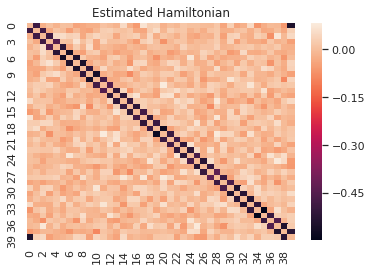

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.heatmap(wN.reshape(L,L))
plt.title("Estimated Hamiltonian")
plt.show()

### The Posterior Distribution

* We now have the full posterior $P(\vec{w}|D)$
* We can see how the probability changes as we move in parameter space away from the MAP estimate
    * i.e. how confident we would be in points near $\vec{w}_{MAP}$ 
* We only show the posterior for four of the parameters.


In [13]:
import matplotlib.pyplot as plt
dw = 0.001
w_range = np.arange(-1.,1., dw)

#print(w_range)
def Pw(index1,index2):
    
    index = index1*L + index2
    vec = wN.copy()
    
    logs = np.zeros(len(w_range))
    for k in range(len(w_range)):
        w = w_range[k]
        vec[index] = w
        logs[k] = -0.5 * np.dot(np.dot((vec - wN).T, VN_inv),vec - wN)
    
    logs -= np.max(logs)
    P = np.exp(logs)
    return P 

def plot_w_distribution(ax, index1,index2,show=False):
    P = Pw(index1,index2)
    ax.plot(w_range,P, label="$P(w_{%.i,%.i}|D)$" % (index1,index2))
    ax.legend()
    if show:
        plt.show()


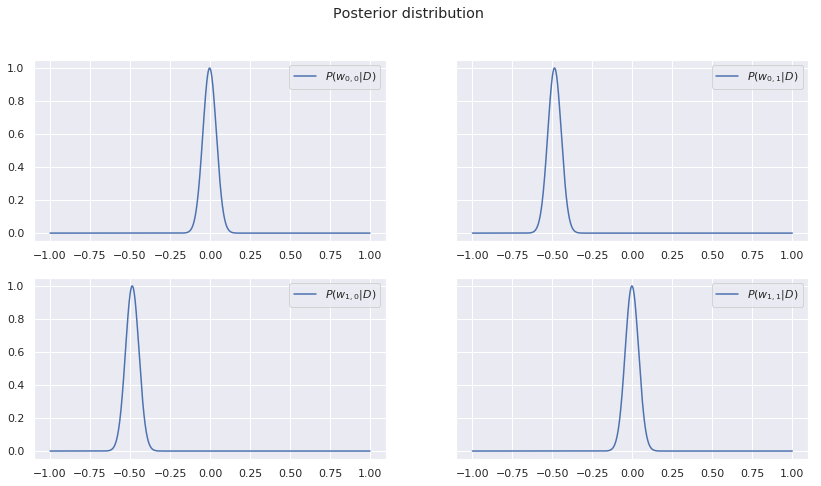

In [19]:
import seaborn as sns
sns.set
fig, axes = plt.subplots(2,2,sharex=False, sharey=True)
fig.set_size_inches(18.5*0.75, 10.5*0.7)
plot_w_distribution(axes[0,0], 0,0,show=False)
plot_w_distribution(axes[0,1],0,1,show=False)
plot_w_distribution(axes[1,0],1,0,show=False)
plot_w_distribution(axes[1,1],1,1,show=False)
fig.suptitle("Posterior distribution")
plt.show()

### Credible Intervals

* We will show the 95 % HDI (Highest Density Interval) 
    * Means the region that contains 95 % of the probability mass 
    * Where all points in the region are higher than the ones outside. 
* This area is not necessarily contiguous if the PDF is multimodal
* But since the posterior here is gaussian, it is monomodal and the HDI is the same as the Central Interval.


* Algorithm used to find the HDI region: 
    * Turning the curve upside down and filling it with water drop by drop

In [17]:
def credible_interval(ax, index1, index2):
    P_ = Pw(index1,index2)
    # normalize
    P_normed = P_ / np.sum(P_)
    
    ############################
    # Water filling algorithm: #
    ############################
    #points = np.zeros_like(P_normed, dtype=np.int)
    points_taken= []
    points = []
    done = False
    t = 0
    while not done:
        best=0
        bestindex=0
        for i in range(len(P_normed)-1):
            if i not in points_taken:
                val = P_normed[i]
                if val > best:
                    best = val
                    bestindex = i
        points_taken.append(bestindex)
        points.append(best)
        if np.sum(points) >= 0.95:
            done=True
    
    points_taken = np.array(points_taken, dtype=np.int)
    argsorted = np.argsort(points_taken)

    points_taken = points_taken[argsorted]
    
    
    plot_w_distribution(ax, index1,index2,show=False)
    first_lastw = [w_range[points_taken[0]], w_range[points_taken[-1]]]
    first_lastP = [P_[points_taken[0]], P_[points_taken[-1]]]

    
    fill = np.zeros(len(points_taken)+2)
    fill[1:-1] = P_[points_taken]
    
    w_range_fill = np.zeros_like(fill)
    w_range_fill[1:-1] = w_range[points_taken]
    w_range_fill[0] = w_range_fill[1]
    w_range_fill[-1] = w_range_fill[-2]
    
    ax.fill(w_range_fill,fill,facecolor="red",alpha=0.5)
    
    line = [P_[points_taken[0]],P_[points_taken[-1]]] 
    line = np.ones(2)*P_[points_taken[0]] # looks better, but not actually totally correct
    ax.plot(first_lastw,line, "k", alpha=0.5)


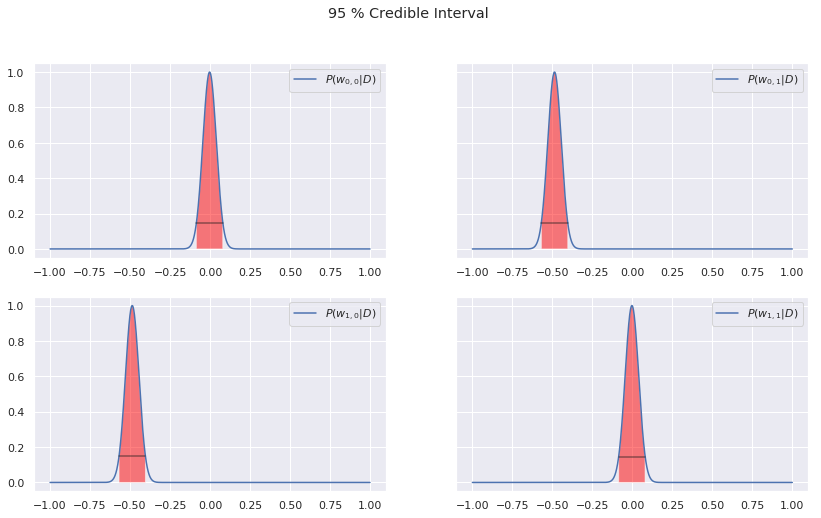

In [18]:
sns.set()
fig, axes = plt.subplots(2,2,sharex=False, sharey=True)
fig.set_size_inches(18.5*0.75, 10.5*0.75)
credible_interval(axes[0,0], 0,0); credible_interval(axes[0,1],0,1)
credible_interval(axes[1,0],1,0); credible_interval(axes[1,1],1,1)
plt.suptitle("95 % Credible Interval")
plt.show()

### Test data

* We can evaluate the performance by calculationg the __coefficient of determination__, given by

$$
\begin{align}
R^2 &=  \big(1-\frac{u}{v}\big),\\
u &= \big(y_{\text{predicted}} - y_{\text{true}}\big)^2 \\
v &= \big(y_{\text{predicted}} - \langle y_{\text{true}}\rangle\big)^2
\end{align}
$$

* The best possible score is then $R^2=1$, but it can also be negative. 
* A model that always only predicts the expected value of $y$, $ \langle y_{\text{true}}\rangle$, disregarding the input features, would get a $R^2$ score of 0 [4].

In [34]:
test_states=np.random.choice([-1, 1], size=(1000,L))
# calculate Ising test energies
test_energies=ising_energies(test_states)

# remapping states:
test_states = np.einsum('bi,bo->bio',test_states,test_states)
test_states = test_states.reshape(test_states.shape[0],-1)

predicted_energies = np.dot(test_states, wN)


### R^2 - coefficient of determination
y_true_avg = np.mean(test_energies)
residuals = predicted_energies - test_energies
u = np.dot(residuals,residuals)
v = test_energies - y_true_avg
v = np.dot(v,v)

R_squared = 1 - u/v

print(R_squared)


0.92679016596241


# Part 3 - Bayesian Neural Networks
### The Essence
A general classical neural network is a function on the form

\begin{equation}
    \mathcal{F}(\vec{x}) = g_L(\boldsymbol{W}^L \ g_{L-1}(\boldsymbol{W}^{L-1} \dots g_1(\boldsymbol{W}^1\vec{x}) \dots  )),
\end{equation}

where the weights are elements in the matrices $\boldsymbol{W}^l$ and $g_l: \mathbb{R}^k \rightarrow \mathbb{R}^k$ are activation functions. For any arbitrary architecture we denote the total number of parameters in such a network by $N$.

In a Bayesian Neural Network with the same architecture, the number of parameters is instead $2N$. Instead of the parameters (weights) being a point estimate, each weight $w_{ij}$ in the classical neural net is instead switched out with two parameters $\mu_{ij}$ and $\sigma_{ij}$ which are the mean and standard deviation in a normal distribution. When we do a forward pass and need the weight, we just sample it from this distribution, i.e.

$$
w_{ij} \sim \mathcal{N}(\mu_{ij}, \sigma_{ij}^2)
$$

where the trainable parameters are now $\theta = \{ \mu, \sigma^2 \}$


The full posterior is in other words not just useful for finding credible intervals, but for sampling! It gives us only twice the number of parameters for in principle an infinite ensemble of networks.

The figure below is an illustration of the difference between a frequentist and a Bayesian CNN. 

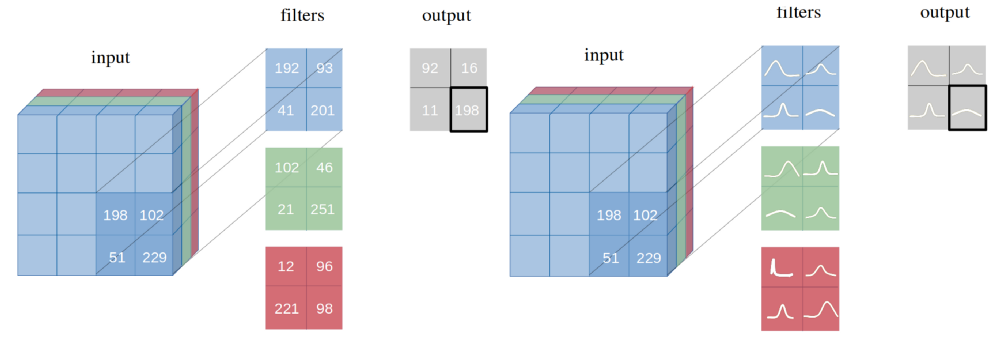
Source: Shridhar et al. [1].

### The Math 
We want to find the posterior
$$
p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}
$$

so that we can use this to do inference 
$$
p(y^i|x^i,D) = \int p(y^i|x^i,\theta)p(\theta|D)d\theta.
$$

This can be understood as checking how much we believe datapoint $x^i$ belongs to class $y^i$ for all possible hypothesises $\theta$ while weighing for how much we believe in each $\theta$, based on the data. $D = \{d_i\}$ are the class labels for $X=\{x_i\}$.


Let our Bayesian Neural Network model $q_\theta$ be a multivariate Gaussian approximation to the true posterior $p$.

$$
q_\theta(w|D) \approx p(w|D)
$$

and then minimize the Kullback-Leibler (KL) divergence between the two distributions


$$
\theta_{opt} = \underset{\theta}{\text{argmin}} \ \text{KL} \ \big[q_\theta(w|D)||p(w|D)\big].
$$

The KL divergence is a measure of how close two distributions are to each other, and is defined as

$$
\text{KL} \ \big[q_\theta(w|D)||p(w|D)\big] = \int q_\theta(w|D) \log \frac{q_\theta(w|D)}{p(w|D)}dw.
$$

This can also be seen as the expectation value of $\log \dfrac{q_\theta(w|D)}{p(w|D)}$ with respect to $q_\theta(w|D)$, i.e.

$$
\text{KL} \ \big[q_\theta(w|D)||p(w|D)\big] = \mathbb{E}_{q_\theta(w|D)}\big[\log \frac{q_\theta(w|D)}{p(w|D)}\big].
$$

The right side can be approximated as a discrete sum 

$$
\mathbb{E}_{q_\theta(w|D)}\big[\log \frac{q_\theta(w|D)}{p(w|D)}\big] \approx \frac{1}{m}\sum_i^m \log \frac{q_\theta(w^i|D)}{p(w^{i}|D)}.
$$

We then substitute $p(w^i|D) = \dfrac{p(D|w^i)p(w^i)}{p(D)}$ and use the rule for the logarithm of fractions, i.e. $\log \frac{a}{b} = \log a - \log b$, so that we get

$$
\mathbb{E}_{q_\theta(w|D)}\big[\log \frac{q_\theta(w|D)}{p(w|D)}\big] \approx \frac{1}{m}\sum_i^m \log {q_\theta(w^i|D)} - \log p(w^i) - \log p(D|w^i)   + \log p(D)
$$

This is a tractable objective function that can be minimized with respect to $\theta = (\mu, \sigma^2)$ by variational methods, Monte Carlo, evolutionary algorithms or other optimizing schemes. The term $\log p(D)$ is just a constant, so we can remove that. 

The optimum can now be found as

\begin{equation}
\boxed{
\begin{align}
\theta_{opt} & = \underset{\theta}{\text{argmin}} \frac{1}{m}\sum_i^m \log {q_\theta(w^i|D)} - \log p(w^i) - \log p(D|w^i) \\
& = \underset{\theta}{\text{argmin}} \ \text{KL} \ \big[q_\theta(w|D)||p(w)\big] - \mathbb{E}_{q_\theta(w|D)}\big[\log p(D|w^i)\big]
\end{align}
}
\end{equation}


by sampling $w^i$ from $q_\theta(w|D)$. This is also known as the __evidence lower bound__ (ELBO).

NB!
For simplicity we have skipped the conditioning on the input data $X$.
So e.g. $\log P(D|w^i)$ should really be understood as $\log P(D|w^i, X)$, meaning that it looks at the probability of setting the correct labels for the data $X$.

### Training a Bayesian Convolutional Neural Net on the 2D Ising model

The 2D Ising model undergoes a phase transition around a critical temperature $T_c$ where it switches from the disordered to the ordered state. The idea is to train a classifier on states that we know are ordered or disordered, and then after use that classifier on states from the transition state / critical region.

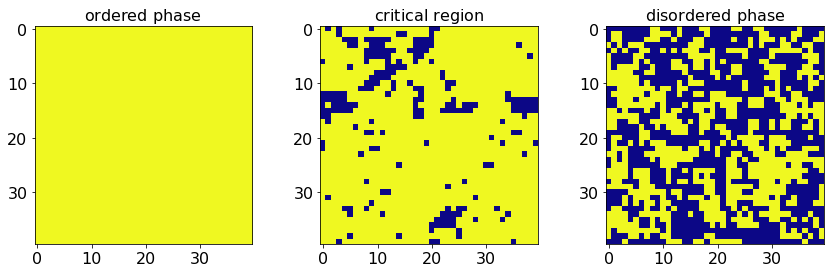
Source: Mehta et al. [4] 

The following code trains a Bayesian Neural Network to classify states of the 2 dimensional Ising model by minimizing the ELBO, using a minimizing scheme called Flipout [1]. The architecture is LeNet-5 [3]. 

It is written using TensorFlow Probability, a library built on TensorFlow for doing probabilistic machine learning. The script is built on the code at the following Github repository https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py, modified for using the Ising model data.

In [1]:
"""Trains a Bayesian neural network to classify data from the 2D Ising model.
The architecture is LeNet-5 [1].
#### References
[1]: Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner.
     Gradient-based learning applied to document recognition.
     _Proceedings of the IEEE_, 1998.
     http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

# Dependency imports
from absl import flags
import matplotlib
matplotlib.use("Agg")
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.contrib.learn.python.learn.datasets import mnist



# TODO(b/78137893): Integration tests currently fail with seaborn imports.
warnings.simplefilter(action="ignore")

try:
    import seaborn as sns  # pylint: disable=g-import-not-at-top
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False

tfd = tfp.distributions

ISING = True

IMAGE_SHAPE = [40,40,1] if ISING else [28, 28, 1] 

flags.DEFINE_float("learning_rate",
                   default=0.001,
                   help="Initial learning rate.")
flags.DEFINE_integer("max_steps",
                     default=6000,
                     help="Number of training steps to run.")
flags.DEFINE_integer("batch_size",
                     default=128,
                     help="Batch size.")
flags.DEFINE_string("data_dir",
                    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                                         "bayesian_neural_network/data"),
                    help="Directory where data is stored (if using real data).")
flags.DEFINE_string(
    "model_dir",
    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"),
                         "bayesian_neural_network/"),
    help="Directory to put the model's fit.")
flags.DEFINE_integer("viz_steps",
                     default=400,
                     help="Frequency at which save visualizations.")
flags.DEFINE_integer("num_monte_carlo",
                     default=50,
                     help="Network draws to compute predictive probabilities.")
flags.DEFINE_bool("fake_data",
                  default=None,
                  help="If true, uses fake data. Defaults to real data.")

FLAGS = flags.FLAGS

def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
    """Save a PNG plot with histograms of weight means and stddevs.
    Args:
    names: A Python `iterable` of `str` variable names.
    qm_vals: A Python `iterable`, the same length as `names`,
        whose elements are Numpy `array`s, of any shape, containing
        posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
        whose elements are Numpy `array`s, of any shape, containing
        posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
    """
    fig = figure.Figure(figsize=(6, 3))
    canvas = backend_agg.FigureCanvasAgg(fig)

    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(qm.flatten(), ax=ax, label=n)
    ax.set_title("weight means")
    ax.set_xlim([-1.5, 1.5])
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(qs.flatten(), ax=ax)
    ax.set_title("weight stddevs")
    ax.set_xlim([0, 1.])

    fig.tight_layout()
    
    canvas.print_figure(fname, format="png")
    print("saved {}".format(fname))


def plot_heldout_prediction(input_vals, label_vals, probs,
                            fname, n=10, title=""):
    """Save a PNG plot visualizing posterior uncertainty on heldout data.
    Args:
    input_vals: A `float`-like Numpy `array` of shape
        `[num_heldout] + IMAGE_SHAPE`, containing heldout input images.
    probs: A `float`-like Numpy array of shape `[num_monte_carlo,
        num_heldout, num_classes]` containing Monte Carlo samples of
        class probabilities for each heldout sample.
    fname: Python `str` filename to save the plot to.
    n: Python `int` number of datapoints to vizualize.
    title: Python `str` title for the plot.
    """
    fig = figure.Figure(figsize=(9, 3*n))
    canvas = backend_agg.FigureCanvasAgg(fig)
    indices = np.random.randint(low=0,high=input_vals.shape[0],size=n)
    for i in range(n):
        ax = fig.add_subplot(n, 3, 3*i + 1)
        ax.imshow(input_vals[indices[i], :].reshape(IMAGE_SHAPE[:-1]), interpolation="None")

        ax = fig.add_subplot(n, 3, 3*i + 2)
        for prob_sample in probs:
            sns.barplot(np.arange(2) if ISING else np.arange(10), prob_sample[indices[i], :], alpha=1/FLAGS.num_monte_carlo, ax=ax)
            ax.set_ylim([0, 1])
        ax.set_title("posterior samples")

        ax = fig.add_subplot(n, 3, 3*i + 3)
        sns.barplot(np.arange(2) if ISING else np.arange(10), np.mean(probs[:, indices[i], :], axis=0), ax=ax)
        ax.set_ylim([0, 1])
        ax.set_title("predictive probs, correct=%.i" % label_vals[indices[i]] )
        
    fig.suptitle(title)
    fig.tight_layout()

    canvas.print_figure(fname, format="png")
    print("saved {}".format(fname))



def plot_test_prediction(input_vals, probs,
                            fname, n=10, title=""):
    """Save a PNG plot visualizing posterior uncertainty on heldout data.
    Args:
    input_vals: A `float`-like Numpy `array` of shape
        `[num_heldout] + IMAGE_SHAPE`, containing heldout input images.
    probs: A `float`-like Numpy array of shape `[num_monte_carlo,
        num_heldout, num_classes]` containing Monte Carlo samples of
        class probabilities for each heldout sample.
    fname: Python `str` filename to save the plot to.
    n: Python `int` number of datapoints to vizualize.
    title: Python `str` title for the plot.
    """
    fig = figure.Figure(figsize=(9, 3*n))
    canvas = backend_agg.FigureCanvasAgg(fig)
    indices = np.random.randint(low=0,high=input_vals.shape[0],size=n)
    for i in range(n):
        ax = fig.add_subplot(n, 3, 3*i + 1)
        ax.imshow(input_vals[indices[i], :].reshape(IMAGE_SHAPE[:-1]), interpolation="None")

        ax = fig.add_subplot(n, 3, 3*i + 2)
        for prob_sample in probs:
            sns.barplot(np.arange(2) if ISING else np.arange(10), prob_sample[indices[i], :], alpha=1/FLAGS.num_monte_carlo, ax=ax)
            ax.set_ylim([0, 1])
        ax.set_title("posterior samples")

        ax = fig.add_subplot(n, 3, 3*i + 3)
        sns.barplot(np.arange(2) if ISING else np.arange(10), np.mean(probs[:, indices[i], :], axis=0), ax=ax)
        ax.set_ylim([0, 1])
        ax.set_title("predictive probs, test set")
        
    fig.suptitle(title)
    fig.tight_layout()

    canvas.print_figure(fname, format="png")
    print("saved {}".format(fname))

def build_input_pipeline(mnist_data, batch_size, heldout_size):
    """Build an Iterator switching between train and heldout data."""

    # Build an iterator over training batches.
    training_dataset = tf.data.Dataset.from_tensor_slices(
        (mnist_data.train.images, np.int32(mnist_data.train.labels)))

    print(mnist_data.train.images.shape)
    training_batches = training_dataset.shuffle(
        50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
    training_iterator = tf.compat.v1.data.make_one_shot_iterator(training_batches)

    # Build a iterator over the heldout set with batch_size=heldout_size,
    # i.e., return the entire heldout set as a constant.
    heldout_dataset = tf.data.Dataset.from_tensor_slices(
        (mnist_data.validation.images,
        np.int32(mnist_data.validation.labels)))
    heldout_frozen = (heldout_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
    heldout_iterator = tf.compat.v1.data.make_one_shot_iterator(heldout_frozen)


    test_dataset = tf.data.Dataset.from_tensor_slices(
        (mnist_data.test.images,
        np.int32(mnist_data.test.labels)))
    test_frozen = (test_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
    test_iterator = tf.compat.v1.data.make_one_shot_iterator(test_frozen)


    # Combine these into a feedable iterator that can switch between training
    # and validation inputs.
    handle = tf.compat.v1.placeholder(tf.string, shape=[])
    feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
        handle, training_batches.output_types, training_batches.output_shapes)
    images, labels = feedable_iterator.get_next()

    return images, labels, handle, training_iterator, heldout_iterator, test_iterator


def test_data_pipeline(mnist_data, batch_size):
    """Build an Iterator switching between train and heldout data."""


    # Build a iterator over the heldout set with batch_size=heldout_size,
    # i.e., return the entire heldout set as a constant.
    heldout_dataset = tf.data.Dataset.from_tensor_slices(
        (mnist_data.test.images))
    heldout_frozen = (heldout_dataset.take(batch_size).
                    repeat().batch(batch_size))
    test_iterator = tf.compat.v1.data.make_one_shot_iterator(heldout_frozen)

    # Combine these into a feedable iterator that can switch between training
    # and test inputs.
    handle = tf.compat.v1.placeholder(tf.string, shape=[])
    feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
        handle, heldout_dataset.output_types, heldout_dataset.output_shapes)
    images = feedable_iterator.get_next()

    return images, handle, test_iterator


def Get_ising_data():
    import pickle
    
    
    def read_t(t,root="/home/samknu/MyRepos/MLProjectIsingModel/data/IsingData/"):
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
        return np.unpackbits(data).astype(int).reshape(-1,1600)
    
    temperatures = np.arange(0.25, 4., step=0.25)
    
    ordered = np.zeros(shape=(np.sum(temperatures<2.0),10000,1600))
    disordered = np.zeros(shape=(np.sum(temperatures>2.5),10000,1600))
    critical = np.zeros(shape=(np.sum((temperatures>=2.0)*(temperatures<=2.5)),10000,1600))
    
    ordered_index = 0
    disordered_index = 0
    crit_index = 0
    for i in range(len(temperatures)):
        T = temperatures[i]
        if T < 2.0:
            ordered[ordered_index] = read_t(T)
            ordered_index += 1
        elif T > 2.5:
            disordered[disordered_index] = read_t(T)
            disordered_index += 1
        else:
            critical[crit_index] = read_t(T)
            crit_index += 1

    ordered = ordered.reshape(-1,1600)       # 70000
    disordered = disordered.reshape(-1,1600) # 50000
    critical = critical.reshape(-1,1600)     # 30000

    # Shuffling before separating into training, validation and test set
    np.random.shuffle(ordered)
    np.random.shuffle(disordered)
    np.random.shuffle(critical)

    training_data = np.zeros((6000*12,1600))
    validation_data = np.zeros((2000*12,1600))
    test_data = np.zeros((2000*12 + 10000*3,1600))

    training_data[:round(0.6*70000)] = ordered[:round(0.6*70000)]
    training_data[round(0.6*70000):] = disordered[:round(0.6*50000)]

    validation_data[:round(0.2*70000)] = ordered[round(0.6*70000):round(0.6*70000)+round(0.2*70000)]
    validation_data[round(0.2*70000):] = disordered[round(0.6*50000):round(0.6*50000)+round(0.2*50000)]

    test_data[:round(0.2*70000)] = ordered[round(0.6*70000)+round(0.2*70000):round(0.6*70000)+2*round(0.2*70000)]
    test_data[round(0.2*70000):round(0.2*70000)+round(0.2*50000)] = disordered[round(0.6*50000)+round(0.2*50000):round(0.6*50000)+2*round(0.2*50000)]
    test_data[round(0.2*70000)+round(0.2*50000):] = critical

    training_labels = np.zeros(6000*12)
    training_labels[round(0.6*70000):] = np.ones(round(0.6*50000))

    validation_labels = np.zeros(2000*12)
    validation_labels[round(0.2*70000):] = np.ones(round(0.2*50000))

    # Class 0 is ordered, class 1 is disordered

    ############################################################
    # Reshaping since we want them as matrices for convolution #
    ############################################################
    training_data = training_data.reshape(-1,40,40)
    training_data = training_data[:,:,:,np.newaxis]

    validation_data = validation_data.reshape(-1,40,40)
    validation_data = validation_data[:,:,:,np.newaxis]
    
    test_data = test_data.reshape(-1,40,40)
    test_data = test_data[:,:,:,np.newaxis]
    

    del ordered
    del disordered
    del critical
    del temperatures

    
    #############################
    # Shuffling data and labels #
    #############################
    indices = np.random.permutation(np.arange(training_data.shape[0]))
    training_data = training_data[indices]
    training_labels = training_labels[indices]
    
    indices = np.random.permutation(np.arange(validation_data.shape[0]))
    validation_data = validation_data[indices]
    validation_labels = validation_labels[indices]
    
    indices = np.random.permutation(np.arange(test_data.shape[0]))
    test_data = test_data[indices]
    #test_labels = test_labels[indices]
    
    cut_train = 20000   
    cut_val = 5000
    cut_test = 1000
    training_data = training_data[:cut_train]
    training_labels = training_labels[:cut_train]

    validation_data = validation_data[:cut_val]
    validation_labels = validation_labels[:cut_val]
    
    test_data = test_data[:cut_test]

    class Dummy(object):
        pass
    ising_data = Dummy()
    ising_data.train=Dummy()
    ising_data.train.images = training_data
    ising_data.train.labels = training_labels
    ising_data.train.num_examples = training_data.shape[0]

    ising_data.validation=Dummy()
    ising_data.validation.images = validation_data
    ising_data.validation.labels = validation_labels
    ising_data.validation.num_examples = validation_data.shape[0]


    ising_data.test=Dummy()
    ising_data.test.images = test_data
    ising_data.test.labels = np.zeros(test_data.shape[0])   # dummy labels
    ising_data.test.num_examples = test_data.shape[0]

    return ising_data


def main(argv):
    del argv  # unused

    if tf.io.gfile.exists(FLAGS.model_dir):
        tf.compat.v1.logging.warning(
            "Warning: deleting old log directory at {}".format(FLAGS.model_dir))
        tf.io.gfile.rmtree(FLAGS.model_dir)
    tf.io.gfile.makedirs(FLAGS.model_dir)



    if ISING:
        the_data = Get_ising_data()
    else:
        the_data = mnist.read_data_sets(FLAGS.data_dir, reshape=False)

    
    (images, labels, handle, training_iterator, heldout_iterator, test_iterator) = build_input_pipeline(
           the_data, FLAGS.batch_size, the_data.validation.num_examples)  


    # Build a Bayesian LeNet5 network. We use the Flipout Monte Carlo estimator
    # for the convolution and fully-connected layers: this enables lower
    # variance stochastic gradients than naive reparameterization.
    with tf.compat.v1.name_scope("bayesian_neural_net", values=[images]):
        neural_net = tf.keras.Sequential([
            tfp.layers.Convolution2DFlipout(6,
                                            kernel_size=5,
                                            padding="SAME",
                                            activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                            strides=[2, 2],
                                            padding="SAME"),
            tfp.layers.Convolution2DFlipout(16,
                                            kernel_size=5,
                                            padding="SAME",
                                            activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D(pool_size=[2, 2],
                                            strides=[2, 2],
                                            padding="SAME"),
            tfp.layers.Convolution2DFlipout(120,
                                            kernel_size=5,
                                            padding="SAME",
                                            activation=tf.nn.relu),
            tf.keras.layers.Flatten(),
            tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
            tfp.layers.DenseFlipout(2) if ISING else tfp.layers.DenseFlipout(10)
            ])
    
    logits = neural_net(images)
    labels_distribution = tfd.Categorical(logits=logits)

    # Compute the -ELBO as the loss, averaged over the batch size.
    neg_log_likelihood = -tf.reduce_mean(
        input_tensor=labels_distribution.log_prob(labels))
    kl = sum(neural_net.losses) / the_data.train.num_examples     # 72000 is the size of the training set
    elbo_loss = neg_log_likelihood + kl

    # Build metrics for validation. Predictions are formed from a single forward
    # pass of the probabilistic layers. They are cheap but noisy predictions.
    predictions = tf.argmax(input=logits, axis=1)
    accuracy, accuracy_update_op = tf.compat.v1.metrics.accuracy(
        labels=labels, predictions=predictions)

    # Extract weight posterior statistics for layers with weight distributions
    # for later visualization.
    names = []
    qmeans = []
    qstds = []
    for i, layer in enumerate(neural_net.layers):
        try:
            q = layer.kernel_posterior
        except AttributeError:
            continue
        names.append("Layer {}".format(i))
        qmeans.append(q.mean())
        qstds.append(q.stddev())


    with tf.compat.v1.name_scope("train"):
        optimizer = tf.compat.v1.train.AdamOptimizer(
            learning_rate=FLAGS.learning_rate)
        train_op = optimizer.minimize(elbo_loss)

    init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                        tf.compat.v1.local_variables_initializer())

    with tf.compat.v1.Session() as sess:
        sess.run(init_op)

        # Run the training loop.
        train_handle = sess.run(training_iterator.string_handle())
        heldout_handle = sess.run(heldout_iterator.string_handle())
        test_handle = sess.run(test_iterator.string_handle())
        
        for step in range(FLAGS.max_steps):
            #for step in range(0):
            _ = sess.run([train_op, accuracy_update_op],
                        feed_dict={handle: train_handle})
            if step % 100 == 0:
                loss_value, accuracy_value = sess.run(
                    [elbo_loss, accuracy], feed_dict={handle: train_handle})
                print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
                    step, loss_value, accuracy_value))

            if (step+1) % FLAGS.viz_steps == 0:
                # Compute log prob of heldout set by averaging draws from the model:
                # p(heldout | train) = int_model p(heldout|model) p(model|train)
                #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
                # where model_i is a draw from the posterior p(model|train).
                probs = np.asarray([sess.run((labels_distribution.probs),
                                            feed_dict={handle: heldout_handle})
                                    for _ in range(FLAGS.num_monte_carlo)])
                mean_probs = np.mean(probs, axis=0)

                image_vals, label_vals = sess.run((images, labels),
                                                feed_dict={handle: heldout_handle})
                
                
                probs_test = np.asarray([sess.run((labels_distribution.probs),
                                            feed_dict={handle: test_handle})
                                    for _ in range(FLAGS.num_monte_carlo)])
                mean_probs_test = np.mean(probs_test, axis=0)
                image_vals_test = sess.run((images),
                                                feed_dict={handle: test_handle})

                heldout_lp = np.mean(np.log(mean_probs[np.arange(mean_probs.shape[0]),
                                                    label_vals.flatten()]))
                                                    
                print(" ... Held-out nats: {:.3f}".format(heldout_lp))

                qm_vals, qs_vals = sess.run((qmeans, qstds))

                if HAS_SEABORN:
                    plot_weight_posteriors(names, qm_vals, qs_vals,
                                            fname=os.path.join(
                                                FLAGS.model_dir,
                                                "step{:05d}_weights.png".format(step)))

                    plot_heldout_prediction(image_vals, label_vals, probs,
                                            fname=os.path.join(
                                                FLAGS.model_dir,
                                                "step{:05d}_pred.png".format(step)),
                                            title="mean heldout logprob {:.2f}"
                                            .format(heldout_lp))

                    plot_test_prediction(image_vals_test, probs_test,
                                            fname=os.path.join(
                                                FLAGS.model_dir,
                                                "step{:05d}_test_pred.png".format(step)))


if __name__ == "__main__":
    
    tf.compat.v1.app.run()      # this thing will run the main(argv) function with sys.argv as argument

W0819 14:36:59.205778 139905242498880 <ipython-input-1-230026a501af>:382] Warning: deleting old log directory at /tmp/bayesian_neural_network/


(20000, 40, 40, 1)


W0819 14:37:06.755785 139905242498880 deprecation.py:323] From <ipython-input-1-230026a501af>:222: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
W0819 14:37:06.756347 139905242498880 deprecation.py:323] From <ipython-input-1-230026a501af>:222: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Step:   0 Loss: 138.476 Accuracy: 0.586
Step: 100 Loss: 129.432 Accuracy: 0.944
Step: 200 Loss: 124.605 Accuracy: 0.968
Step: 300 Loss: 119.741 Accuracy: 0.978
 ... Held-out nats: -0.029
saved /tmp/bayesian_neural_network/step00399_weights.png
saved /tmp/bayesian_neural_network/step00399_pred.png
saved /tmp/bayesian_neural_network/step00399_test_pred.png
Step: 400 Loss: 114.933 Accuracy: 0.980
Step: 500 Loss: 110.023 Accuracy: 0.983
Step: 600 Loss: 105.147 Accuracy: 0.986
Step: 700 Loss: 100.314 Accuracy: 0.988
 ... Held-out nats: -0.004
saved /tmp/bayesian_neural_network/step00799_weights.png
saved /tmp/bayesian_neural_network/step00799_pred.png
saved /tmp/bayesian_neural_network/step00799_test_pred.png
Step: 800 Loss: 95.513 Accuracy: 0.989
Step: 900 Loss: 90.747 Accuracy: 0.990
Step: 1000 Loss: 86.024 Accuracy: 0.991
Step: 1100 Loss: 81.355 Accuracy: 0.992
 ... Held-out nats: -0.002
saved /tmp/bayesian_neural_network/step01199_weights.png
saved /tmp/bayesian_neural_network/step01199

SystemExit: 

Weights near the beginning:
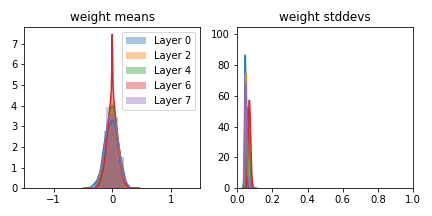
Weights near the end:
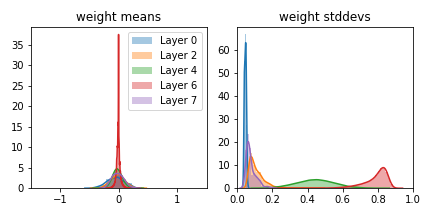

### Classification on the unseen data:
(The data includes both ordered and disordered in addition to the critical state)

Class 0 = ordered, Class 1 = disordered
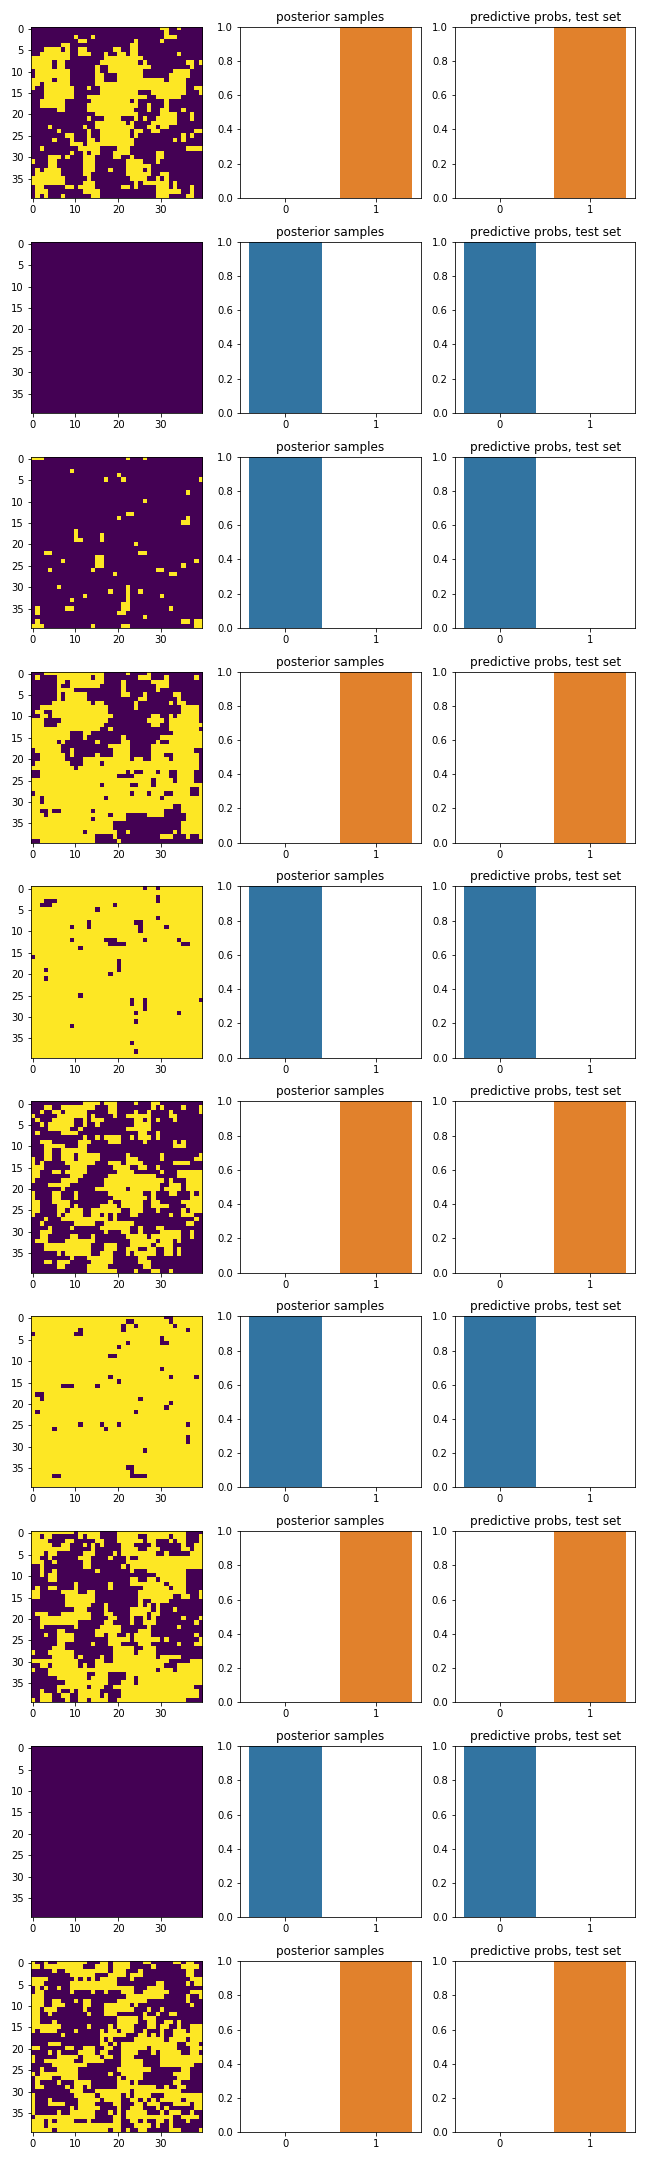

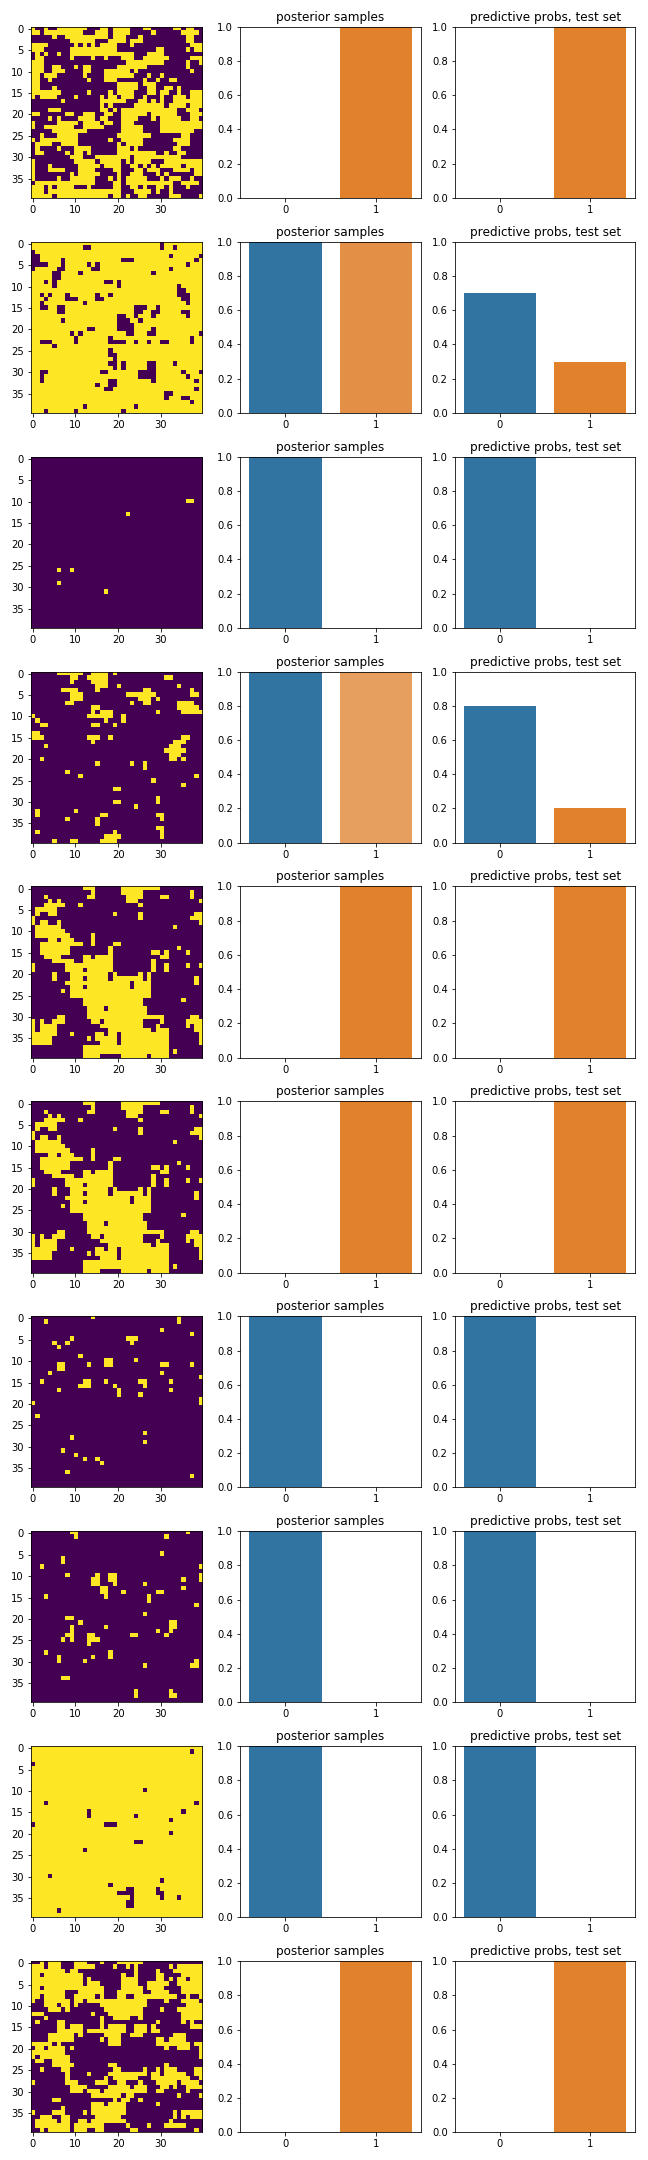

# Part 4 - Bayesian Reasoning on the Probability of Life

A frequentist will claim that we cannot say anything about the probability that life can arise, because we have only observed a single example of it. Here I will give a Bayesian explanation of why this intuition is wrong.

In Bayesian logic we can use other types of information about life on Earth to do inference -- in this case the datapoint that life on Earth seems to have appeared very shortly after the planet cooled down enough to allow for complex molecules to exist. The reasoning goes like this:

Let us say that we _initially_ only know two facts:
    1. Life exist on Earth 
    2. We also have a modern understanding of biology, meaning that we know that life is essentially an extension of thermodynamics, but we have no information about the actual probability of life to spontaneously appear


We now ask ourselves if we can say something about the probability of life to occur or not. To simplify the analysis we assume a binary hypothesis space $\theta$ where 


$$
          \theta = 0 \ \text{is the hypothesis that life has a} \textbf{ low } \text{probability of occurring}\\
          \theta = 1 \ \text{is the hypothesis that life has a} \textbf{ high } \text{probability of occurring}.          
$$


The question is then which of these hypotheses is true. Since we are initially completely ignorant, meaning we have no reason to believe either hypothesis more than the other, we start with a uniform prior, i.e.

$$
p(\theta=0) = 0.5
$$
and
$$
p(\theta=1) = 0.5 .
$$


Let us then assume that we observe a datapoint 
$$D = \{\textrm{Life appeared shortly after it was possible}\}.$$ 

Using Bayes theorem we can then write our two posterior estimates as

$$
p(\theta=0|D) = \frac{p(D|\theta=0)p(\theta=0)}{p(D)}
$$
and
$$
p(\theta=1|D) = \frac{p(D|\theta=1)p(\theta=1)}{p(D)}
$$


The denominators are the same in both cases, and since the priors are $p(\theta=0)=p(\theta=1)$ we see that the only factors that differ between the two posterior hypotheses are the likelihood factors $p(D|\theta=1)$ and $p(D|\theta=0)$.


Further it must be true that $p(D|\theta=1)>p(D|\theta=0)$, since observing datapoint $D$ is more probable if $\theta=1$ than if $\theta=0$, so it follows that

$$
p(\theta=1|D) > p(\theta=0|D). 
$$

So we conclude that our posterior, based on this single datapoint $D$, says that we should give a higher probability estimate that $\theta=1$ is true. In other words, we should lend more credence to the hypothesis that life has a high probability of occurring.

We could also do this analysis with a continuous hypothesis space. Our prior would then not be uniform, but would fall to zero towards the right end, because we know that if life were extremely, extremely probable we would have seen it arise in experiments, which we have not.